## import libraries

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
env = gym.make('CliffWalking-v0')

In [2]:
class ActorCriticModel(nn.Module):

  def __init__(self, n_input, n_output, n_hidden):
    super(ActorCriticModel, self).__init__()
    self.fc1 = nn.Linear(n_input, n_hidden[0])
    self.fc2 = nn.Linear(n_hidden[0], n_hidden[1])
    self.action = nn.Linear(n_hidden[1], n_output)
    self.value = nn.Linear(n_hidden[1], 1)

  def forward(self, x):
    x = torch.Tensor(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))    
    action_probs = F.softmax(self.action(x), dim=-1)
    state_values = self.value(x)
    return action_probs, state_values

In [3]:
class PolicyNetwork():

  def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):

    self.model = ActorCriticModel(n_state, n_action, n_hidden)
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
    self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.9)
  
  def predict(self, s):
    return self.model(torch.Tensor(s))
  
  def update(self, returns, log_probs, state_values):
    loss = 0
    for log_prob, value, Gt in zip(log_probs, state_values, returns):
      advantage = Gt - value.item()
      policy_loss = -log_prob * advantage
      value_loss = F.smooth_l1_loss(value, Gt)
      loss += policy_loss + value_loss
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def get_action(self, s):
    action_probs, state_value = self.predict(s)
    action = torch.multinomial(action_probs, 1).item()
    log_prob = torch.log(action_probs[action])
    return action, log_prob, state_value
  
  

In [4]:
def actor_critic(env, estimator, n_episode, gamma=1.0):

  for episode in range(n_episode):
    log_probs = []
    rewards = []
    state_values = []
    state = env.reset()
    while True:
      one_hot_state = [0] * 48
      one_hot_state[state] = 1
      action, log_prob, state_value = estimator.get_action(one_hot_state)
      next_state, reward, is_done, _ = env.step(action)
      total_reward_episode[episode] += reward
      log_probs.append(log_prob)
      state_values.append(state_value)
      rewards.append(reward)
      if is_done:
        returns = []
        Gt = 0
        pw = 0
        for reward in rewards[::-1]:
          Gt += gamma ** pw * reward
          pw += 1
          returns.append(Gt)
        returns = returns[::-1]
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)
        estimator.update(returns, log_probs, state_values)
        if episode % 20 == 0:
          print('Episode: {}, total reward: {}'.format(episode, total_reward_episode[episode]))
        if total_reward_episode[episode] >= -14:
          estimator.scheduler.step()
        break
      state = next_state

In [5]:
n_state = 48
n_action = env.action_space.n
n_hidden = [128, 32]
lr = 0.03
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)

In [6]:
gamma = 0.9
n_episode = 1000
total_reward_episode = [0] * n_episode
actor_critic(env, policy_net, n_episode, gamma)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Episode: 0, total reward: -49251
Episode: 20, total reward: -7144
Episode: 40, total reward: -4033
Episode: 60, total reward: -1874
Episode: 80, total reward: -333
Episode: 100, total reward: -24
Episode: 120, total reward: -18
Episode: 140, total reward: -19
Episode: 160, total reward: -16
Episode: 180, total reward: -15
Episode: 200, total reward: -30
Episode: 220, total reward: -126
Episode: 240, total reward: -17
Episode: 260, total reward: -15
Episode: 280, total reward: -16
Episode: 300, total reward: -15
Episode: 320, total reward: -15
Episode: 340, total reward: -15
Episode: 360, total reward: -20
Episode: 380, total reward: -16
Episode: 400, total reward: -15
Episode: 420, total reward: -16
Episode: 440, total reward: -18
Episode: 460, total reward: -15
Episode: 480, total reward: -19
Episode: 500, total reward: -16
Episode: 520, total reward: -15
Episode: 540, total reward: -16
Episode: 560, total reward: -15
Episode: 580, total reward: -15
Episode: 600, total reward: -16
Epi

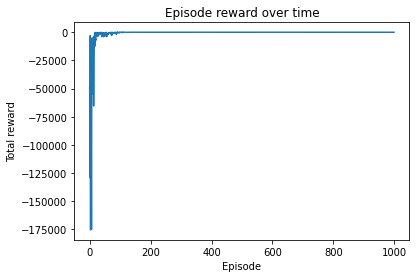

In [7]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()